In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/Data.zip" -d "/content/Data"

In [ ]:
import os
import librosa
import math
import json
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
dataset_path = r"/content/Data/genres_original"
json_path = r"data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [ ]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048,
             hop_length=512, num_segments=5):
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(SAMPLES_PER_TRACK/num_segments)
    expected_vects_ps = math.ceil(samples_ps/hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            data["mapping"].append(semantic_label)
            print(f"Processing: {semantic_label}")

            for f in filenames:
                if(f==str("jazz.00054.wav")):
                    continue
                else:
                    file_path = os.path.join(dirpath, f)
                    signal,sr = librosa.load(file_path,sr=SAMPLE_RATE)
                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps

                        mfcc = librosa.feature.mfcc(
                                          y=signal[start_sample:finish_sample],
                                          sr=sr,
                                          n_fft=n_fft,
                                          n_mfcc=n_mfcc,
                                          hop_length=hop_length
                                      )


                        mfcc = mfcc.T
                        if len(mfcc)==expected_vects_ps:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print(f"{file_path}, segment: {s+1}")

    with open(json_path,"w") as f:
        json.dump(data,f,indent=4)

In [ ]:
from IPython.display import clear_output

In [ ]:
save_mfcc(dataset_path,json_path,num_segments=10)
clear_output()

In [ ]:
filepath = r"/content/Data/genres_original/blues/blues.0000"

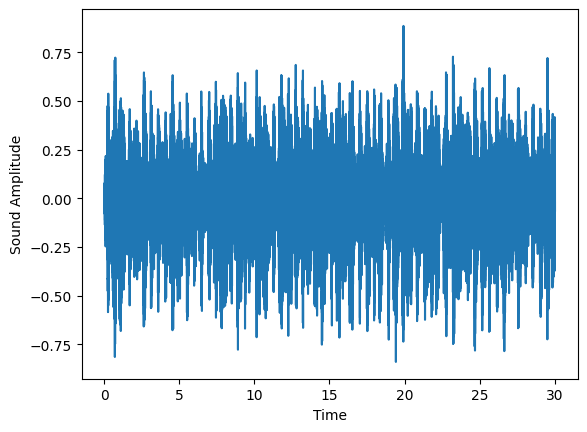

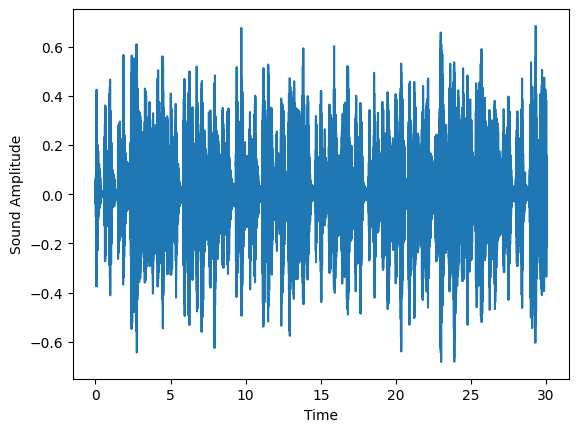

In [ ]:
for i in range(2):
    audio, sfreq = librosa.load(filepath+str(i)+".wav")
    time = np.arange(0, len(audio))/sfreq
    plt.plot(time,audio)
    plt.xlabel("Time")
    plt.ylabel("Sound Amplitude")
    plt.show()

In [ ]:
import json
import numpy as np

In [ ]:
def load_data(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)

    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs,targets

In [ ]:
inputs,targets = load_data(r"./data.json")

In [ ]:
from sklearn.model_selection import train_test_split

input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3)
print(input_train.shape, target_train.shape)

(6990, 130, 13) (6990,)


# NN

In [ ]:
from tensorflow import keras
from keras import Sequential
from keras.layers import *

In [ ]:
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       865,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,014,218 (3.87 MB)

 Trainable params: 1,014,218 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(learning_rate=1e-4)

In [ ]:
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)
clear_output()

In [ ]:
def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)

    axs[0].plot(hist.history["accuracy"], label="train accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

<Figure size 2000x1500 with 0 Axes>

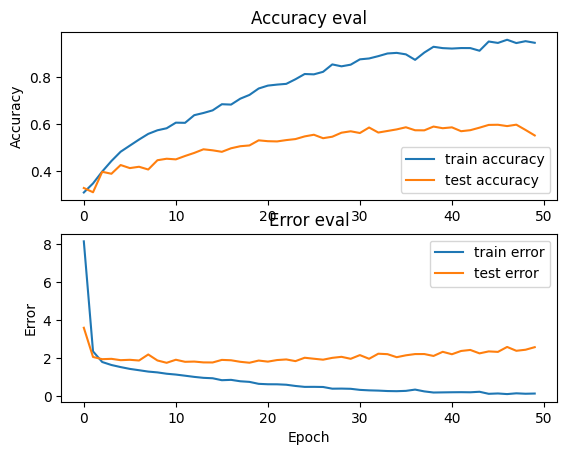

In [ ]:
plot_history(hist)

In [ ]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5577 - loss: 2.4955
Test accuracy: 0.5527369976043701


# Overfitting

Making architecture less complicated

Using augmented data

Early stopping of training

Adding dropout layers

Regularization / Standardization

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       865,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,015,978 (3.88 MB)

 Trainable params: 1,015,978 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

hist = model.fit(input_train, target_train,
          validation_data=(input_test, target_test),
          epochs=50,
          batch_size=32,
          callbacks=[early_stopping])

Epoch 1/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.1286 - loss: 20.2876 - val_accuracy: 0.1121 - val_loss: 4.7267
Epoch 2/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.1253 - loss: 4.7241 - val_accuracy: 0.1602 - val_loss: 4.4288
Epoch 3/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1598 - loss: 4.4019 - val_accuracy: 0.1739 - val_loss: 4.1946
Epoch 4/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1733 - loss: 4.1685 - val_accuracy: 0.2800 - val_loss: 3.8113
Epoch 5/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2367 - loss: 3.8760 - val_accuracy: 0.3248 - val_loss: 3.5847
Epoch 6/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2535 - loss: 3.6746 - val_accuracy: 0.3194 - val_loss: 3.4129
Epoch 7/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2476 - loss: 3.4948 - val_accuracy: 0.3087 - val_loss: 3.1852
Epoch 8/50
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2715 - loss: 3.2668 - val_accuracy:

<Figure size 2000x1500 with 0 Axes>

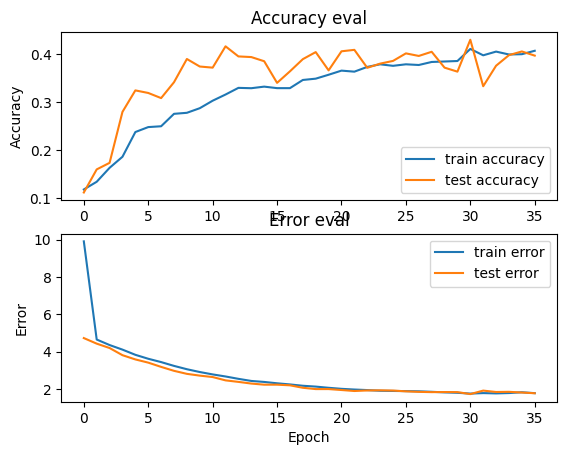

In [ ]:
plot_history(hist)

In [ ]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4255 - loss: 1.7246
Test accuracy: 0.43024033308029175


# CNN

In [ ]:
def prepare_dataset(test_size, validation_size):
    X,y = load_data(r"./data.json")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

In [ ]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(130, 13, 1)


In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 11, 64)    │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 4, 32)      │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 1, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 1, 16)      │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 1, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 1, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,242 (129.85 KB)

 Trainable params: 32,954 (128.73 KB)

 Non-trainable params: 288 (1.12 KB)

In [ ]:
from tensorflow.keras import optimizers
adam = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=adam,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 70,
                 batch_size = 32)

Epoch 1/70
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.1190 - loss: 2.9419 - val_accuracy: 0.2116 - val_loss: 2.1784
Epoch 2/70
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.2511 - loss: 2.2117 - val_accuracy: 0.3318 - val_loss: 1.9168
Epoch 3/70
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.3587 - loss: 1.8887 - val_accuracy: 0.3912 - val_loss: 1.7009
Epoch 4/70
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3741 - loss: 1.7684 - val_accuracy: 0.4366 - val_loss: 1.5611
Epoch 5/70
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4271 - loss: 1.6214 - val_accuracy: 0.4553 - val_loss: 1.4925
Epoch 6/70
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4600 - loss: 1.5272 - val_accuracy: 0.4780 - val_loss: 1.4148
Epoch 7/70
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4777 - loss: 1.4549 - val_accuracy: 0.5107 - val_loss: 1.3473
Epoch 8/70
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4869 - loss: 1.4200 - val_accuracy

<Figure size 2000x1500 with 0 Axes>

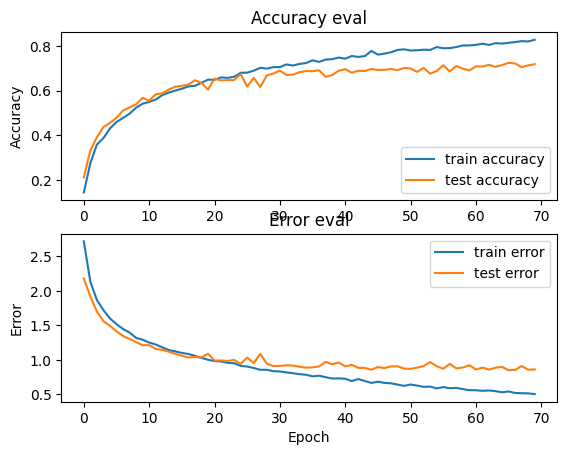

In [ ]:
plot_history(hist)

In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7366 - loss: 0.8178
Test accuracy: 0.7276732325553894


In [ ]:
def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")

In [ ]:
predict(model, X_test[10], y_test[10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
Expected index: 5, Predicted index: [5]


# RNN

In [24]:
num_classes = len(np.unique(y_train))

In [25]:
from keras import optimizers
from tensorflow.keras import layers, models, optimizers
input_shape = (X_train.shape[1], X_train.shape[2])

model = models.Sequential()
model.add(layers.LSTM(64, return_sequences=True, input_shape=input_shape))
model.add(layers.Dropout(0.3))
model.add(layers.GRU(64))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


In [27]:
optimizer = optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=60,
                    batch_size=32)

Epoch 1/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.1191 - loss: 2.3279 - val_accuracy: 0.2330 - val_loss: 2.1761
Epoch 2/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2250 - loss: 2.1679 - val_accuracy: 0.2991 - val_loss: 2.0262
Epoch 3/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.2849 - loss: 2.0390 - val_accuracy: 0.3204 - val_loss: 1.8981
Epoch 4/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3223 - loss: 1.9113 - val_accuracy: 0.3411 - val_loss: 1.8163
Epoch 5/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3441 - loss: 1.8494 - val_accuracy: 0.3518 - val_loss: 1.7588
Epoch 6/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3539 - loss: 1.7970 - val_accuracy: 0.3798 - val_loss: 1.6993
Epoch 7/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3798 - loss: 1.7391 - val_accuracy: 0.3952 - val_loss: 1.6494
Epoch 8/60
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.3918 - loss: 1.6929 - val_accu

In [28]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6663 - loss: 1.0364
Test accuracy: 0.6631958484649658


In [46]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

def build_crnn_attention(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2,2))(x)

    x = layers.TimeDistributed(layers.Flatten())(x)

    x = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)

    scores  = layers.Dense(1)(x)                 # (batch, t, 1)
    weights = layers.Softmax(axis=1)(scores)     # (batch, t, 1)
    context = layers.Dot(axes=1)([weights, x])   # (batch, 1, features)
    context = layers.Flatten()(context)          # (batch, features)

    x = layers.Dense(128, activation='relu')(context)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

input_shape = (130, 64, 1)
num_classes = 10

model = build_crnn_attention(input_shape, num_classes)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 130, 64,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 130, 64,   │        320 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 130, 64,   │        128 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 65, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 65, 32,    │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 65, 32,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 32, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 32, 1024)  │          0 │ max_pooling2d_8[… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 32, 256)   │    886,272 │ time_distributed… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32, 256)   │          0 │ bidirectional_3[… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 32, 1)     │        257 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_3 (Softmax) │ (None, 32, 1)     │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_3 (Dot)         │ (None, 1, 256)    │          0 │ softmax_3[0][0],  │
│                     │                   │            │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 256)       │          0 │ dot_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     32,896 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_13[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 10)        │      1,290 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 939,915 (3.59 MB)

 Trainable params: 939,723 (3.58 MB)

 Non-trainable params: 192 (768.00 B)

In [47]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    inputs, targets,
    test_size=0.3,
    random_state=42,
    stratify=targets
)
print("X_train:", X_train.shape, "X_val:", X_val.shape)



X_train: (6990, 130, 13) X_val: (2996, 130, 13)


In [48]:
model = build_crnn_attention(input_shape=(130,13,1), num_classes=10)
from tensorflow.keras import optimizers
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [49]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
    ]
)


Epoch 1/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.3137 - loss: 1.9514 - val_accuracy: 0.4933 - val_loss: 1.4706 - learning_rate: 1.0000e-04
Epoch 2/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5092 - loss: 1.3697 - val_accuracy: 0.6045 - val_loss: 1.1700 - learning_rate: 1.0000e-04
Epoch 3/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.5672 - loss: 1.2176 - val_accuracy: 0.6429 - val_loss: 1.0149 - learning_rate: 1.0000e-04
Epoch 4/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6223 - loss: 1.0910 - val_accuracy: 0.6986 - val_loss: 0.9202 - learning_rate: 1.0000e-04
Epoch 5/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6551 - loss: 0.9968 - val_accuracy: 0.7377 - val_loss: 0.8223 - learning_rate: 1.0000e-04
Epoch 6/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6983 - loss: 0.9132 - val_accuracy: 0.7517 - val_loss: 0.7711 - learning_rate: 1.0000e-04
Epoch 7/40
219/219 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - ac

In [51]:
import numpy as np

# Приведём X_test и y_test к NumPy, если это не так
X_test = np.array(X_test)
y_test = np.array(y_test)

print("X_test type:", type(X_test))
print("X_test shape:", X_test.shape)


X_test type: <class 'numpy.ndarray'>
X_test shape: (2497, 130, 13, 1)


In [52]:
import numpy as np

X_test_rnn = np.squeeze(X_test, axis=-1)

print("X_test_rnn shape:", X_test_rnn.shape)

test_loss, test_accuracy = model.evaluate(X_test_rnn, y_test, verbose=2)
print(f"\n✅ Test loss: {test_loss:.4f}")
print(f"✅ Test accuracy: {test_accuracy:.4f}")

X_test_rnn shape: (2497, 130, 13)
79/79 - 0s - 6ms/step - accuracy: 0.9600 - loss: 0.1426

✅ Test loss: 0.1426
✅ Test accuracy: 0.9600


In [53]:
model.save('genre_crnn_attention.h5')
print("Модель сохранена в файл genre_crnn_attention.h5")

Модель сохранена в файл genre_crnn_attention.h5


In [38]:
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# ===============================
# 1. Feature Extraction Function
# ===============================

def extract_features_from_file(file_path, sr=22050, duration=30, n_mfcc=13, hop_length=512):
    try:
        signal, _ = librosa.load(file_path, sr=sr, duration=duration)
        if len(signal) < sr * duration:
            pad_length = sr * duration - len(signal)
            signal = np.pad(signal, (0, pad_length), mode='constant')

        # MFCC
        mfcc = librosa.feature.mfcc(signal, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length)
        mfcc = mfcc[:130, :]  # ensure consistent shape

        # Chroma
        chroma = librosa.feature.chroma_stft(y=signal, sr=sr, hop_length=hop_length)
        chroma = chroma[:130, :]

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y=signal, hop_length=hop_length)
        zcr = zcr[:, :130]

        # Concatenate
        features = np.concatenate((mfcc, chroma, zcr), axis=0)
        features = features.T[:130, :]  # (time, features)

        return features

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# ===============================
# 2. Model Architecture
# ===============================

def build_crnn_attention(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Reshape((input_shape[0], input_shape[1], 1))(inputs)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((2, 2))(x)

    shape = x.shape
    x = layers.Reshape((shape[1], -1))(x)

    x = layers.Bidirectional(layers.GRU(128, return_sequences=True))(x)
    x = layers.Dropout(0.3)(x)

    # Attention
    scores = layers.Dense(1)(x)
    weights = layers.Softmax(axis=1)(scores)
    context = layers.Dot(axes=1)([weights, x])
    context = layers.Flatten()(context)

    x = layers.Dense(128, activation='relu')(context)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model


In [39]:
X_train = np.squeeze(X_train)
X_val = np.squeeze(X_val)

# Добавим только один канал (если нужно)
if X_train.ndim == 3:  # (samples, 130, 13)
    X_train = X_train[..., np.newaxis]  # => (samples, 130, 13, 1)
    X_val = X_val[..., np.newaxis]

# Создание модели
input_shape = (130, 13, 1)
model = build_crnn_attention(input_shape=input_shape, num_classes=10)

# Компиляция
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Обучение
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    ],
    verbose=2
)


Epoch 1/40

Epoch 1: val_loss improved from inf to 1.41860, saving model to best_model.h5


219/219 - 9s - 41ms/step - accuracy: 0.4303 - loss: 1.6373 - val_accuracy: 0.4983 - val_loss: 1.4186 - learning_rate: 1.0000e-04
Epoch 2/40

Epoch 2: val_loss improved from 1.41860 to 1.07198, saving model to best_model.h5


219/219 - 4s - 19ms/step - accuracy: 0.5555 - loss: 1.2569 - val_accuracy: 0.6335 - val_loss: 1.0720 - learning_rate: 1.0000e-04
Epoch 3/40

Epoch 3: val_loss improved from 1.07198 to 0.91479, saving model to best_model.h5


219/219 - 6s - 28ms/step - accuracy: 0.6328 - loss: 1.0697 - val_accuracy: 0.6933 - val_loss: 0.9148 - learning_rate: 1.0000e-04
Epoch 4/40

Epoch 4: val_loss improved from 0.91479 to 0.84220, saving model to best_model.h5


219/219 - 4s - 19ms/step - accuracy: 0.6788 - loss: 0.9403 - val_accuracy: 0.7106 - val_loss: 0.8422 - learning_rate: 1.0000e-04
Epoch 5/40

Epoch 5: val_loss improved from 0.84220 to 0.73995, saving model to best_model.h5


219/219 - 3s - 14ms/step - accuracy: 0.7126 - loss: 0.8563 - val_accuracy: 0.7460 - val_loss: 0.7399 - learning_rate: 1.0000e-04
Epoch 6/40

Epoch 6: val_loss improved from 0.73995 to 0.70281, saving model to best_model.h5


219/219 - 6s - 28ms/step - accuracy: 0.7422 - loss: 0.7571 - val_accuracy: 0.7647 - val_loss: 0.7028 - learning_rate: 1.0000e-04
Epoch 7/40

Epoch 7: val_loss improved from 0.70281 to 0.64864, saving model to best_model.h5


219/219 - 4s - 18ms/step - accuracy: 0.7628 - loss: 0.7026 - val_accuracy: 0.7790 - val_loss: 0.6486 - learning_rate: 1.0000e-04
Epoch 8/40

Epoch 8: val_loss improved from 0.64864 to 0.63344, saving model to best_model.h5


219/219 - 5s - 24ms/step - accuracy: 0.7887 - loss: 0.6396 - val_accuracy: 0.7857 - val_loss: 0.6334 - learning_rate: 1.0000e-04
Epoch 9/40

Epoch 9: val_loss improved from 0.63344 to 0.59493, saving model to best_model.h5


219/219 - 6s - 26ms/step - accuracy: 0.8096 - loss: 0.5803 - val_accuracy: 0.7977 - val_loss: 0.5949 - learning_rate: 1.0000e-04
Epoch 10/40

Epoch 10: val_loss improved from 0.59493 to 0.54698, saving model to best_model.h5


219/219 - 5s - 21ms/step - accuracy: 0.8253 - loss: 0.5245 - val_accuracy: 0.8128 - val_loss: 0.5470 - learning_rate: 1.0000e-04
Epoch 11/40

Epoch 11: val_loss improved from 0.54698 to 0.52835, saving model to best_model.h5


219/219 - 5s - 25ms/step - accuracy: 0.8409 - loss: 0.4815 - val_accuracy: 0.8101 - val_loss: 0.5284 - learning_rate: 1.0000e-04
Epoch 12/40

Epoch 12: val_loss did not improve from 0.52835
219/219 - 5s - 21ms/step - accuracy: 0.8604 - loss: 0.4332 - val_accuracy: 0.8151 - val_loss: 0.5468 - learning_rate: 1.0000e-04
Epoch 13/40

Epoch 13: val_loss did not improve from 0.52835
219/219 - 5s - 22ms/step - accuracy: 0.8687 - loss: 0.3962 - val_accuracy: 0.8128 - val_loss: 0.5369 - learning_rate: 1.0000e-04
Epoch 14/40

Epoch 14: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 14: val_loss did not improve from 0.52835
219/219 - 3s - 16ms/step - accuracy: 0.8805 - loss: 0.3723 - val_accuracy: 0.7954 - val_loss: 0.6033 - learning_rate: 1.0000e-04
Epoch 15/40

Epoch 15: val_loss improved from 0.52835 to 0.47831, saving model to best_model.h5


219/219 - 5s - 22ms/step - accuracy: 0.9031 - loss: 0.3026 - val_accuracy: 0.8395 - val_loss: 0.4783 - learning_rate: 5.0000e-05
Epoch 16/40

Epoch 16: val_loss improved from 0.47831 to 0.47416, saving model to best_model.h5


219/219 - 3s - 14ms/step - accuracy: 0.9143 - loss: 0.2745 - val_accuracy: 0.8391 - val_loss: 0.4742 - learning_rate: 5.0000e-05
Epoch 17/40

Epoch 17: val_loss did not improve from 0.47416
219/219 - 6s - 27ms/step - accuracy: 0.9217 - loss: 0.2499 - val_accuracy: 0.8405 - val_loss: 0.4765 - learning_rate: 5.0000e-05
Epoch 18/40

Epoch 18: val_loss did not improve from 0.47416
219/219 - 4s - 20ms/step - accuracy: 0.9222 - loss: 0.2490 - val_accuracy: 0.8358 - val_loss: 0.4854 - learning_rate: 5.0000e-05
Epoch 19/40

Epoch 19: val_loss improved from 0.47416 to 0.45532, saving model to best_model.h5


219/219 - 4s - 19ms/step - accuracy: 0.9272 - loss: 0.2288 - val_accuracy: 0.8475 - val_loss: 0.4553 - learning_rate: 5.0000e-05
Epoch 20/40

Epoch 20: val_loss did not improve from 0.45532
219/219 - 5s - 21ms/step - accuracy: 0.9318 - loss: 0.2121 - val_accuracy: 0.8388 - val_loss: 0.4833 - learning_rate: 5.0000e-05
Epoch 21/40

Epoch 21: val_loss improved from 0.45532 to 0.45172, saving model to best_model.h5


219/219 - 4s - 20ms/step - accuracy: 0.9349 - loss: 0.2032 - val_accuracy: 0.8478 - val_loss: 0.4517 - learning_rate: 5.0000e-05
Epoch 22/40

Epoch 22: val_loss did not improve from 0.45172
219/219 - 5s - 24ms/step - accuracy: 0.9492 - loss: 0.1739 - val_accuracy: 0.8488 - val_loss: 0.4579 - learning_rate: 5.0000e-05
Epoch 23/40

Epoch 23: val_loss did not improve from 0.45172
219/219 - 6s - 26ms/step - accuracy: 0.9475 - loss: 0.1691 - val_accuracy: 0.8351 - val_loss: 0.4936 - learning_rate: 5.0000e-05
Epoch 24/40

Epoch 24: val_loss improved from 0.45172 to 0.45161, saving model to best_model.h5


219/219 - 5s - 22ms/step - accuracy: 0.9514 - loss: 0.1623 - val_accuracy: 0.8501 - val_loss: 0.4516 - learning_rate: 5.0000e-05
Epoch 25/40

Epoch 25: val_loss did not improve from 0.45161
219/219 - 5s - 22ms/step - accuracy: 0.9516 - loss: 0.1529 - val_accuracy: 0.8471 - val_loss: 0.4682 - learning_rate: 5.0000e-05
Epoch 26/40

Epoch 26: val_loss did not improve from 0.45161
219/219 - 5s - 23ms/step - accuracy: 0.9581 - loss: 0.1403 - val_accuracy: 0.8451 - val_loss: 0.4679 - learning_rate: 5.0000e-05
Epoch 27/40

Epoch 27: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 27: val_loss did not improve from 0.45161
219/219 - 5s - 22ms/step - accuracy: 0.9599 - loss: 0.1326 - val_accuracy: 0.8448 - val_loss: 0.4639 - learning_rate: 5.0000e-05
Epoch 28/40

Epoch 28: val_loss did not improve from 0.45161
219/219 - 6s - 27ms/step - accuracy: 0.9645 - loss: 0.1108 - val_accuracy: 0.8578 - val_loss: 0.4548 - learning_rate: 2.5000e-05
Epoch 29/40

Epoch 29: val_loss i

219/219 - 4s - 19ms/step - accuracy: 0.9712 - loss: 0.0990 - val_accuracy: 0.8575 - val_loss: 0.4420 - learning_rate: 2.5000e-05
Epoch 30/40

Epoch 30: val_loss did not improve from 0.44204
219/219 - 3s - 15ms/step - accuracy: 0.9744 - loss: 0.0906 - val_accuracy: 0.8555 - val_loss: 0.4537 - learning_rate: 2.5000e-05
Epoch 31/40

Epoch 31: val_loss did not improve from 0.44204
219/219 - 6s - 27ms/step - accuracy: 0.9754 - loss: 0.0927 - val_accuracy: 0.8555 - val_loss: 0.4675 - learning_rate: 2.5000e-05
Epoch 32/40

Epoch 32: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 32: val_loss did not improve from 0.44204
219/219 - 4s - 19ms/step - accuracy: 0.9755 - loss: 0.0902 - val_accuracy: 0.8548 - val_loss: 0.4532 - learning_rate: 2.5000e-05
Epoch 33/40

Epoch 33: val_loss did not improve from 0.44204
219/219 - 5s - 23ms/step - accuracy: 0.9808 - loss: 0.0752 - val_accuracy: 0.8625 - val_loss: 0.4503 - learning_rate: 1.2500e-05
Epoch 34/40

Epoch 34: val_loss d

In [40]:
X_test = np.squeeze(X_test)
if X_test.ndim == 3:
    X_test = X_test[..., np.newaxis]

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")

X_test shape: (2497, 130, 13, 1)
y_test shape: (2497,)
79/79 - 1s - 6ms/step - accuracy: 0.9503 - loss: 0.1646

✅ Test Accuracy: 0.9503


# Проверка модели на новых треках из fma_small

In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/fma_small.zip"
extract_path = "/content/fma_small"

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

In [ ]:
import shutil

dst_path = "/content/drive/MyDrive/fma_small"

if not os.path.exists(dst_path):
    shutil.copytree("/content/fma_small", dst_path)
    print("Папка успешно скопирована в Google Диск.")
else:
    print("Папка уже существует в Google Диске.")

In [41]:
import shutil
import random
from glob import glob

source_dir = "/content/drive/MyDrive/fma_small/fma_small"
sample_dir = "/content/drive/MyDrive/sample"
os.makedirs(sample_dir, exist_ok=True)

all_mp3 = glob(os.path.join(source_dir, '**', '*.mp3'), recursive=True)
sample_files = random.sample(all_mp3, 10)

for file_path in sample_files:
    shutil.copy(file_path, sample_dir)


In [42]:
!apt-get install ffmpeg -y
!pip install pydub

from pydub import AudioSegment

wav_sample_dir = "/content/drive/MyDrive/sample_wav"
os.makedirs(wav_sample_dir, exist_ok=True)

for file_path in os.listdir(sample_dir):
    if file_path.endswith('.mp3'):
        mp3_path = os.path.join(sample_dir, file_path)
        wav_path = os.path.join(wav_sample_dir, file_path.replace('.mp3', '.wav'))
        sound = AudioSegment.from_mp3(mp3_path)
        sound.export(wav_path, format="wav")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [54]:
import json
import numpy as np
import librosa
from tensorflow.keras.models import load_model

model = load_model('genre_crnn_attention.h5')
with open('data.json', 'r') as f:
    metadata = json.load(f)
mapping = metadata['mapping']

SAMPLE_RATE   = 22050
DURATION      = 30
SAMPLES_TRACK = SAMPLE_RATE * DURATION
NUM_SEGMENTS  = 10
N_MFCC        = 13
N_FFT         = 2048
HOP_LENGTH    = 512

In [55]:
def extract_mfcc(file_path):
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
    samples_per_segment = int(SAMPLES_TRACK / NUM_SEGMENTS)
    mfccs = []

    for s in range(NUM_SEGMENTS):
        start = s * samples_per_segment
        end   = start + samples_per_segment
        segment = signal[start:end]

        mfcc = librosa.feature.mfcc(
            y=segment,
            sr=sr,
            n_mfcc=N_MFCC,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH
        ).T

        if mfcc.shape[0] == int(np.ceil(samples_per_segment / HOP_LENGTH)):
            mfccs.append(mfcc)

    return np.array(mfccs)

In [56]:
wav_sample_dir = '/content/drive/MyDrive/sample_wav'

for file_name in os.listdir(wav_sample_dir):
    if not file_name.lower().endswith(".wav"):
        continue

    file_path = os.path.join(wav_sample_dir, file_name)
    mfcc_segments = extract_mfcc(file_path)
    if mfcc_segments.size == 0:
        print(f"{file_name}: не удалось извлечь MFCC")
        continue

    # Подготовка батча для предсказания
    X = mfcc_segments[..., np.newaxis]  # форма (NUM_SEGMENTS, 130, 13, 1)
    preds = model.predict(X, verbose=0)  # форма (NUM_SEGMENTS, 10)

    # Усредняем вероятности по сегментам
    mean_probs = np.mean(preds, axis=0)  # форма (10,)

    # Преобразуем в проценты и округляем
    percent_probs = (mean_probs * 100).round(2)

    # Ищем максимум
    max_idx = np.argmax(percent_probs)

    # Формируем строку с жанрами и процентами
    genre_lines = []
    for idx, genre in enumerate(mapping):
        pct = percent_probs[idx]
        if idx == max_idx:
            # Выделяем жанр с наибольшей вероятностью
            genre_lines.append(f"**{genre}: {pct}%**")
        else:
            genre_lines.append(f"{genre}: {pct}%")

    # Выводим результат
    print(f"\nФайл: {file_name}")
    print("Вероятности по всем жанрам:")
    print("\n".join(genre_lines))
    print("-" * 40)

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (10, 32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Файл: 126675.wav
Вероятности по всем жанрам:
classical: 0.0%
disco: 0.0%
hiphop: 0.0%
**country: 100.0%**
pop: 0.0%
jazz: 0.0%
blues: 0.0%
reggae: 0.0%
rock: 0.0%
metal: 0.0%
----------------------------------------


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Файл: 091170.wav
Вероятности по всем жанрам:
classical: 0.0%
disco: 33.27000045776367%
hiphop: 0.0%
**country: 44.439998626708984%**
pop: 22.290000915527344%
jazz: 0.0%
blues: 0.0%
reggae: 0.0%
rock: 0.0%
metal: 0.0%
----------------------------------------

Файл: 056275.wav
Вероятности по всем жанрам:
classical: 0.0%
disco: 0.0%
hiphop: 10.0%
**country: 50.0%**
pop: 0.0%
jazz: 30.0%
blues: 0.0%
reggae: 0.0%
rock: 10.0%
metal: 0.0%
----------------------------------------

Файл: 059373.wav
Вероятности по всем жанрам:
classical: 33.33000183105469%
disco: 0.0%
hiphop: 0.0%
country: 0.0%
pop: 0.0%
**jazz: 55.560001373291016%**
blues: 0.0%
reggae: 0.0%
rock: 11.109999656677246%
metal: 0.0%
----------------------------------------

Файл: 120326.wav
Вероятности по всем жанрам:
classical: 0.0%
disco: 0.0%
hiphop: 0.0%
country: 33.33000183105469%
pop: 0.0%
**jazz: 66.66999816894531%**
blues: 0.0%
reggae: 0.0%
rock: 0.0%
metal: 0.0%
----------------------------------------

Файл: 098622.wav
Ве

# Cнипет трека

In [ ]:
import torchaudio
import torch

def load_and_chunk_audio(path, chunk_duration_sec=5.0):
    waveform, sample_rate = torchaudio.load(path)
    total_samples = waveform.shape[1]
    chunk_size = int(sample_rate * chunk_duration_sec)

    chunks = []
    for start in range(0, total_samples - chunk_size + 1, chunk_size):
        end = start + chunk_size
        chunk = waveform[:, start:end]
        chunks.append((chunk, start / sample_rate))  # Сохраняем с временной меткой

    return chunks, sample_rate


In [ ]:
def compute_chunk_score(chunk):
    # RMS (энергия)
    energy = chunk.pow(2).mean().item()
    # Спектральная плотность (интереснее высокочастотные фрагменты)
    spec = torch.stft(chunk, n_fft=1024, return_complex=True)
    spectral_energy = spec.abs().mean().item()

    return energy + 0.5 * spectral_energy  # можно настраивать веса


In [ ]:
def find_best_snippet(audio_path, chunk_duration=5.0):
    chunks, sr = load_and_chunk_audio(audio_path, chunk_duration)

    scored_chunks = []
    for chunk, start_time in chunks:
        score = compute_chunk_score(chunk)
        scored_chunks.append((score, start_time))

    best_chunk = max(scored_chunks, key=lambda x: x[0])
    return best_chunk[1], best_chunk[1] + 2*chunk_duration  # start_time, end_time


In [ ]:
import torchaudio
def save_snippet(audio_path, start_sec, end_sec, output_path):
    waveform, sample_rate = torchaudio.load(audio_path)
    start_sample = int(start_sec * sample_rate)
    end_sample = int(end_sec * sample_rate)
    snippet = waveform[:, start_sample:end_sample]
    torchaudio.save(output_path, snippet, sample_rate)


In [ ]:
audio_path = "lady gaga.mp3"
start, end = find_best_snippet(audio_path, chunk_duration=10.0)
save_snippet(audio_path, start, end, "snippet.wav")
print(f"Сниппет: с {start:.2f} до {end:.2f} секунд")
